# Notebook 3: Fitting into Test Data

### Key sections of the notebook:
1. Preparing Testing Data
    - Creating infrastructure to import and clean Whatsapp and Telegram data
2. Data Visualisation of Chat Conversations
3. Fitting Model on Chat Conversations
4. Visualisation of Predicted Results
5. Evaluation of Predicted Emotions
6. Summary and Conclusion

**Key Disclaimer**: These conversations were heavily manipulated for testing purposes. Dates, time, content and users are all fictional. 
We have approached the problem this way in order to maintain privacy as well as to ensure quality presentation of our data, findings and model predictions.

# Data Imports

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import json

# Set style for plots
sns.set_style("darkgrid")
sns.set_palette("Spectral")

# NLP Imports
import regex as re
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
from sklearn.feature_extraction import text
from wordcloud import WordCloud, ImageColorGenerator
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Other Imports
import dill
import janitor
import datetime
from datetime import datetime, timedelta
from dateutil import parser
import emoji

import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly
import plotly.graph_objs as go

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)

### Model Import

In [192]:
filename = '../data/models/gs_lr.model'
best_model = dill.load(open(filename, 'rb'))

In [193]:
# test if loaded successfully
best_model

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('content',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x1a20c55ef0>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(max_features=6500,
                                                                                  min_df=10,
                                                                                  ngram_range=(1,
                                                                                               2)))])),
                                                ('punc_len',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=

### Defining Functions

In [194]:
# Function to convert (supporting function for msg_cleaned function below)  
def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 

def msg_cleaned(text):  

    # Getting text only from mix of html/text
    soup = BeautifulSoup(text,'lxml')
    text = soup.get_text()

    # Removing links:
    text = re.sub('http\S+','',text)
    text = re.sub('www\S+','',text)
    
    # Removal of aprostrophe from text (before sending it to)
    corrected = re.sub("\'","",text)

    # Tokenizing to lemmatize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(corrected)
    lemmatizer = WordNetLemmatizer()
    lemmatized_string = [lemmatizer.lemmatize(w) for w in tokens]

    # Removal of stop words from above list.
    meaningful_words = [w for w in lemmatized_string if not w in stop_list]

    return (listToString(meaningful_words))

def exclaimation(string):
    exc = re.findall('\!',string)
    len_exc = len(exc)
    return len_exc

def questionmark(string):
    qn = re.findall('\?',string)
    len_qn = len(qn)
    return len_qn

def ellipsis(string):
    ell = re.findall('\.\.\.',string)
    len_ell = len(ell)
    return len_ell

def extract_emojis(str):
    return ' '.join(c for c in str if c in emoji.UNICODE_EMOJI)

def add_space(string):
    return(" ".join(string))

def replace_sticker(text):
    text = 'Sticker Present'
    return(text)

dict_emo = {'negativity':1,
            'neutral':2,
            'optimistic':3,
            'anticipation':4,
            'contempt':5}
dict_emo_swap = dict([(value, key) for key, value in dict_emo.items()]) 
dict_emo_swap

{1: 'negativity',
 2: 'neutral',
 3: 'optimistic',
 4: 'anticipation',
 5: 'contempt'}

In [195]:
# The list of stop words to be cleaned from our tweets. These stop words have been added through an iterative process.
newStopWords = ['sticker','omitted','go','got','get','still','lol','okay','sia','btw','leh',
                'haha','min','chester','one','lot','coz','hmmm','zzz','well','also','ehh',
               'aft','shuck','sup','ohh','ooh','meh','want','okayy','oop','oops','smse','lah'
                ,'lor','le','ok','eh','oh','ya','ur','lo','ll','hee','lols','hi','hey',
                'ah','ur','la','bah','ba','rite','just','let','dam','maybe','ooo','sure','ohhh',
                'fine','really','dunno','wo','nee','arh','nvm','day','com','a1','al','did','https',
                'http','tweets','tweet','ed','rt','tweeted','lindseyyx2', ' day', 'day ','sarah',
                'tweet ',' tweet',' tweeter', 'a i','bit ly','bit iy','bit','ly','im','wa','notavailable']
stop_list = text.ENGLISH_STOP_WORDS.union(newStopWords)

### Chat imports

In [196]:
path_tele = '../data/chat/final_chat.json'
path_wa = '../data/chat/sample_2.txt'

### Choosing chat to use    

In [197]:
option = input('telegram/whatsapp: ')
if option == str('telegram'):
    path = path_tele
    print(f"Your document's Path: {path}")
elif option == str('whatsapp'):
    path= path_wa
    print(f"Your document's Path: {path}")
else:
    print("Please impute option correctly: Whatsapp or Telegram")
    print(path)

telegram/whatsapp: telegram
Your document's Path: ../data/chat/final_chat.json


### Whatsapp Path

In [198]:
def read_history(file):
    string = open(file).read()
    new_str = re.sub('\[',"",string)
    new_str = re.sub('\]',"",string)
    #f = open('data/{}'.format(file), 'r')
    #f = open(file,'r') 
    # Every text message has the same format: date - sender: message. 
    messages = re.findall('(\d+/\d+/\d+, \d+:\d+:\d+ [A-Z]*) (.*?): (.*)', new_str)

    #Convert list to a dataframe and name the columns
    history = pd.DataFrame(messages,columns=['datetime','name','msg'])
    try:
        history['datetime'] = pd.to_datetime(history['datetime'],format="%d/%m/%Y, %I:%M:%S %p")
        history['date'] = history['datetime'].apply(lambda x: x.date())
    except:
        history['datetime'] = pd.to_datetime(history['datetime'],format="%d/%m/%y, %I:%M:%S %p")
        history['date'] = history['datetime'].apply(lambda x: x.date())
    

    # file is in the format 'WhatsApp Conversation with XXX.txt'
    history['conv_name'] = file[19:-4]
    
    return history

In [199]:
df_wa = read_history(path_wa)
df_wa.sample(5,random_state=5)

,datetime,name,msg,date,conv_name
6518,2020-04-09 02:51:53,User 2,‎sticker omitted,2020-04-09,_2
5453,2020-03-12 13:22:47,User 2,You are la,2020-03-12,_2
5448,2020-03-12 13:22:26,User 1,Cool,2020-03-12,_2
5020,2020-03-12 12:29:53,User 2,How I know which one,2020-03-12,_2
2892,2019-03-07 11:17:05,User 1,Uh,2019-03-07,_2


### Telegram Path

In [200]:
# Reading Dataframe
with open(path_tele) as f:
    data = json.load(f)
df_tele = pd.json_normalize(data['messages'])

df_tele = df_tele[['date','from','text','sticker_emoji']]

# Converting Datetime to Readable Format
def date_parser(string):
    yourdate = parser.parse(string)
    return yourdate

df_tele['datetime'] = df_tele['date'].map(date_parser)

# Renaming Columns
rename_cols = {'from':'name','text':'msg','sticker_emoji':'sticker'}
df_tele.rename(columns=rename_cols,inplace=True)
df_tele.head()

,date,name,msg,sticker,datetime
0,2020-05-21T18:09:23,User 2,Hello how have you been doing,NaN,2020-05-21 18:09:23
1,2020-06-12T18:09:39,User 2,Life is awesome and I am finishing my stint with this firm,NaN,2020-06-12 18:09:39
2,2020-05-21T18:09:54,User 1,Yeah me too it has been great,NaN,2020-05-21 18:09:54
3,2020-05-24T18:10:02,User 1,Capstone project is finishing yay!,NaN,2020-05-24 18:10:02
4,2020-05-24T18:10:03,User 1,,😛,2020-05-24 18:10:03


### Choosing chat to use    

In [201]:
# Whatsapp:
if path == path_wa:
    chat = df_wa
    print("Using Whatsapp File")
# Telegram:
elif path == path_tele:
    chat = df_tele
    print("Using Telegram File")
else: 
    print("Invalid")

Using Telegram File


# Data Cleaning and Feature Processing

Building infrastructure to clean and process both Whatsapp and Telegram data. The codes below would be used for the following purposes:

**Data Cleaning**
1. In Whatsapp, there are messages labelled as '(media) omitted'. We will be removing these messages as they do not add value. However, stickers is a feature that we are interested in. Hence, will keep them.
2. In Whatsapp, there are also messages which were originally deleted, that were recorded as 'XXX has deleted this message' or 'message was deleted'. We will also be removing these information.
3. Applying the cleaning function that we have consistently used for other notebooks and recording as a new column 'content_final'.

Note: For Telegram data structure, it is slightly different. Stickers are grouped under a seperate column, and we will merge this sticker column with 'message' column to align with Whatsapp's data format. 

**Feature Engineering:**
4. Creating 3 new columns to record number of punctuations used. This is essential to fit into our model.
5. Extraction of emojis and stickers counts.
6. Extraction of message length information.
7. Creation of various datetime variables (year,month,day,weekdayname,dayofyear,time,date)

**Unique Party Identification**
8. Extracting the unique names within chat conversation and registering them.

**Clustering Messages**

Chat messages in todays' world are extremely short in length. A message that may be 2-3 words, may in fact be part of a larger conversation chopped into pieces instead. These extremely short messages may not be representative of the emotions carried along with it. 
Hence, I have decided to group messages in 1-minute blocks so that messages could be sufficient long (but not too long) such that our model can predict the sentiments behind each message. I believe that a 1-minute block is sufficient for grouping a group of chronological messages that are regarding the same issue. 
1. Splitting data in 1 minute blocks and assigning groups (each group represents 1 minute blocks)
2. Splitting chat dataframe into the two users 
  - We will assign groups separately to these two users. Hence, a 1 minute block for each group will only consist of ONE user (instead of two). 
  - We will calculate the usage of emojis, stickers, punctuations separately for each user.
3. Combining chats into main dataframe.
4. Creation of datatime features based on 'avg_datetime' calculated per 1-minute block of data.
5. Creation of message length feature for each block of data.
6. Categorising of the Weekday names to be sequential.

##### For Whatsapp

In [202]:
if path == path_wa:
    print("Using Whatsapp File")
        
    chat = chat[['name','date','datetime','msg']]

    # Removal of 'omitted' media types.
            #As output (media files) are not downloaded in the text file, these messages are not useful for our analysis and would add additional noise.
            #However, we will not be deleting 'sticker omitted' as this information is useful for our analysis

    index_omitted = chat[chat['msg'].str.match('^(?!.*sticker).*omitted')]

    # Further analysis shows that there are also other regular messages. 
    # Messages are not shown further in the notebook due to privacy issues
    index_omitted_2 = chat[chat['msg'].str.contains(r'deleted this message|message was deleted|end-to-end encrypted')]

    # Dropping the messages.
    chat.drop(index=index_omitted.index,inplace=True)
    chat.drop(index=index_omitted_2.index,inplace=True)
    chat.reset_index(inplace = True) 
    
    # Cleaning message
    chat['content_final'] = chat['msg'].apply(msg_cleaned)
    
    # Adding punctuation columns
    chat['len_exc'] = chat['msg'].apply(exclaimation)
    chat['len_qn'] = chat['msg'].apply(questionmark)
    chat['len_ellip'] = chat['msg'].apply(ellipsis)
    
    # Emoji Extraction and Number Count
    chat['emoji']=chat['msg'].apply(lambda x: extract_emojis(x)).apply(lambda x: add_space(x))
    chat['emoji_count']=chat['emoji'].apply(lambda x: len(x))

    # Sticker count
    chat["msg"]= chat["msg"].astype(str) 

    # build column for sticker counts after message 
    sticker_count = []
    msg_index = 0
    for index, row in chat.iterrows(): # iterating over df rows
        flag = True
        count = 0
        # when a sticker row is encountered, just put 0 in the count column
        # when a non-sticker row is encountered do the following
        if row['msg'] != '\u200esticker omitted': 

            k = 1 # to check rows after the non-sticker row
            while flag:
                #print(f'i{msg_index} flag{flag} len{len(chat)}')
                # if the index + k row is a sticker increase the count for index and k
                msg_index=index + k 
                if msg_index >= len(chat):
                    break
                if chat.loc[msg_index].msg == '\u200esticker omitted': 
                    count += 1
                    k += 1
                    # when reached the end of the database, break the loop
                    if msg_index +1 > len(chat):
                        flag = False
                        #print(f'i{msg_index} flag{flag}')
                else:
                    flag = False
                    k = 1                
        sticker_count.append(count)
    chat['sticker_count'] = sticker_count    

    # Dropping messages that are 'sticker omitted' as we accounted for it in new column.
    chat = chat[~chat['msg'].str.contains('sticker omitted')]
    
    # Message length
    chat['msg_len']=chat['content_final'].map(lambda x: len(set(x.split())))
    
    #chat['datetime'] = pd.to_datetime(chat['date'])
    chat['year'] = chat['datetime'].dt.year
    chat['month'] = chat['datetime'].dt.month
    chat['day'] = chat['datetime'].dt.day
    chat['weekdayname'] = chat['datetime'].dt.day_name()
    chat['dayofyear'] = chat['datetime'].dt.dayofyear
    chat['time'] = chat['datetime'].dt.time
    chat['date'] = chat['datetime'].apply(lambda x: x.date())  

    # Creating a list of names that corresponds to unique names in chat dialogue.
    list_of_names = {}
    for i in range(chat['name'].nunique()):
        list_of_names['party_{}'.format(i)] = chat['name'].unique()[i]

    print(list_of_names)

    # Updating global variables with dictionary inputs.
    # Source: https://stackoverflow.com/questions/18090672/convert-dictionary-entries-into-variables-python
    globals().update(list_of_names)

    print(f'Person 1: {party_0}')
    print(f'Person 2: {party_1}')
    
    ######################################### Clustering Messages #########################################
    
    # Splitting data into blocks of 1 minute
    chat_list = chat.values.tolist()
    split_dt = timedelta(minutes=1)
    dts = (d1[3]-d0[3] for d0, d1 in zip(chat_list, chat_list[1:]))
    split_at = [i for i, dt in enumerate(dts, 3) if dt >= split_dt]
    groups = [chat_list[i:j] for i, j in zip([0]+split_at, split_at+[None])]
    
    # Creating dataframe with groups
    chat_cols = chat.columns.tolist()
    chat_cols.append('group')
    chat_clustered = pd.DataFrame([e1 + [g] for g, e0 in enumerate(groups) for e1 in e0],columns = chat_cols)
    
    # Splitting chats by users
    chat_1 = chat_clustered[chat_clustered['name']==party_0]
    chat_2 = chat_clustered[chat_clustered['name']==party_1]

    # Joining messages based on each group and user
    chat_1_grouped = pd.DataFrame(chat_1.groupby('group')['content_final'].apply(lambda x: "%s" % ' '.join(x)))
    chat_2_grouped = pd.DataFrame(chat_2.groupby('group')['content_final'].apply(lambda x: "%s" % ' '.join(x)))

    chat_1_grouped.reset_index(inplace=True)
    chat_2_grouped.reset_index(inplace=True)

    chat_1_grouped['name']=party_0
    chat_2_grouped['name']=party_1

    # Calculating avg. time, emoji count and sticker counts for each time block
    chat_clustered['timestamp'] = pd.to_datetime(chat_clustered['datetime']).values.astype(np.int64)
    
    chat_time_avg_grouped = pd.to_datetime(chat_clustered.groupby('group').mean()['timestamp'])
    chat_emoji_sum_grouped = chat_clustered.groupby('group').sum()['emoji_count']
    chat_sticker_sum_grouped = chat_clustered.groupby('group').sum()['sticker_count']
    
    # Calculating sum of punctuations
    chat_exc_sum_grouped = chat_clustered.groupby('group').sum()['len_exc']
    chat_qn_sum_grouped = chat_clustered.groupby('group').sum()['len_qn']
    chat_ellip_sum_grouped = chat_clustered.groupby('group').sum()['len_ellip']


    # Combining chats.
    combined_chats = chat_1_grouped.append(chat_2_grouped)
    combined_chats = combined_chats.sort_values(by='group')
    combined_chats.reset_index(inplace=True)

    #### Mapping Avg. Datetime and Sticker Count Sum to each group

    # Series object
    combined_chats = pd.merge(combined_chats, chat_sticker_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_emoji_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_time_avg_grouped, how='left', on='group')
    
    combined_chats = pd.merge(combined_chats, chat_exc_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_qn_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_ellip_sum_grouped, how='left', on='group')

    combined_chats.rename(columns={'timestamp':'avg_datetime'},inplace=True)
    combined_chats.head()

    # Creating date-related features
    combined_chats['year'] = combined_chats['avg_datetime'].dt.year
    combined_chats['month'] = combined_chats['avg_datetime'].dt.month
    combined_chats['day'] = combined_chats['avg_datetime'].dt.day
    combined_chats['weekdayname'] = combined_chats['avg_datetime'].dt.day_name()
    combined_chats['dayofyear'] = combined_chats['avg_datetime'].dt.dayofyear
    combined_chats['time'] = combined_chats['avg_datetime'].dt.time
    combined_chats['date'] = combined_chats['avg_datetime'].apply(lambda x: x.date())

    # Obtaining message length
    combined_chats['msg_len']=combined_chats['content_final'].map(lambda x: len(set(x.split())))

    # Categorising days of week
    combined_chats['weekdayname'] = pd.Categorical(combined_chats['weekdayname'], categories=
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
        ordered=True)

else:
    print("This is not a Whatsapp Conversation")

This is not a Whatsapp Conversation


##### For Telegram

In [203]:
chat.head()

,date,name,msg,sticker,datetime
0,2020-05-21T18:09:23,User 2,Hello how have you been doing,NaN,2020-05-21 18:09:23
1,2020-06-12T18:09:39,User 2,Life is awesome and I am finishing my stint with this firm,NaN,2020-06-12 18:09:39
2,2020-05-21T18:09:54,User 1,Yeah me too it has been great,NaN,2020-05-21 18:09:54
3,2020-05-24T18:10:02,User 1,Capstone project is finishing yay!,NaN,2020-05-24 18:10:02
4,2020-05-24T18:10:03,User 1,,😛,2020-05-24 18:10:03


In [204]:
if path == path_tele:
    print("Using Telegram File")

    # Creating a list of names that corresponds to unique names in chat dialogue.
    list_of_names = {}
    for i in range(chat['name'].nunique()):
        list_of_names['party_{}'.format(i)] = chat['name'].unique()[i]

    # Updating global variables with dictionary inputs.
    # Source: https://stackoverflow.com/questions/18090672/convert-dictionary-entries-into-variables-python
    globals().update(list_of_names)
    
    # In telegram chats, documents are registered as a list object.
    chat = chat[chat['msg'].map(type)!=list]
    
    # Cleaning message
    chat['content_final'] = chat['msg'].apply(msg_cleaned)
        
    # Adding punctuation columns
    chat['len_exc'] = chat['msg'].apply(exclaimation)
    chat['len_qn'] = chat['msg'].apply(questionmark)
    chat['len_ellip'] = chat['msg'].apply(ellipsis)
    
    # Emoji Extraction and Number Count
    chat['emoji']=chat['msg'].apply(lambda x: extract_emojis(x)).apply(lambda x: add_space(x))
    chat['emoji_count']=chat['emoji'].apply(lambda x: len(x))
    
    # Transforming the sticker column to be in a similar format to Whatsapp 
    # (Whatsapp combines both msg and sticker together.)
    
    df_convert_sticker = chat[chat['sticker'].notnull()].reset_index()
    df_convert_null_sticker = chat[chat['sticker'].isnull()].reset_index()

    df_convert_sticker['sticker'] = df_convert_sticker['sticker'].map(replace_sticker)
    df_convert_sticker.head()
    
    df_convert_sticker['combined_msg'] = df_convert_sticker[['msg', 'sticker',]].agg(''.join, axis=1)
    df_convert_null_sticker['sticker'].fillna('',inplace=True)
    
    df_convert_null_sticker['combined_msg'] = df_convert_null_sticker[['msg', 'sticker',]].agg(''.join, axis=1)
    
    frames = [df_convert_sticker,df_convert_null_sticker]
    chat = pd.concat(frames).sort_values(by='index').drop(columns='index')
    chat[chat['combined_msg']=='Sticker Present']
    chat = chat.reset_index()
        
    # ------------------------------------------------ Sticker Count -----------------------------------------------$
    # Sticker count
    chat["msg"]= chat["msg"].astype(str) 

    # build column for sticker counts after message 
    sticker_count = []
    msg_index = 0
    for index, row in chat.iterrows(): # iterating over df rows
        flag = True
        count = 0
        # when a sticker row is encountered, just put 0 in the count column
        # when a non-sticker row is encountered do the following
        if row['combined_msg'] != 'Sticker Present': 
            
            k = 1 # to check rows after the non-sticker row
            while flag:
                #print(f'i{msg_index} flag{flag} len{len(chat)}')
                # if the index + k row is a sticker increase the count for index and k
                msg_index=index + k 
                if msg_index >= len(chat):
                    break
                if chat.loc[msg_index]['combined_msg'] =='Sticker Present': 
                    count += 1
                    k += 1
                    # when reached the end of the database, break the loop
                    if msg_index +1 > len(chat):
                        flag = False
                        #print(f'i{msg_index} flag{flag}')
                else:
                    flag = False
                    k = 1                
        sticker_count.append(count)
    chat['sticker_count'] = sticker_count
    
    # Message length
    chat['msg_len']=chat['content_final'].map(lambda x: len(set(x.split())))
    
    #chat['datetime'] = pd.to_datetime(chat['date'])
    chat['year'] = chat['datetime'].dt.year
    chat['month'] = chat['datetime'].dt.month
    chat['day'] = chat['datetime'].dt.day
    chat['weekdayname'] = chat['datetime'].dt.day_name()
    chat['dayofyear'] = chat['datetime'].dt.dayofyear
    chat['time'] = chat['datetime'].dt.time
    chat['date'] = chat['datetime'].apply(lambda x: x.date())  


    ######################################### Clustering Messages #########################################
    
    # Splitting data into blocks of 1 minutes
    chat_list = chat.values.tolist()
    split_dt = timedelta(minutes=1)
    dts = (d1[5]-d0[5] for d0, d1 in zip(chat_list, chat_list[1:]))
    split_at = [i for i, dt in enumerate(dts, 5) if dt >= split_dt]
    groups = [chat_list[i:j] for i, j in zip([0]+split_at, split_at+[None])]
    
    # Creating dataframe with groups
    chat_cols = chat.columns.tolist()
    chat_cols.append('group')
    chat_clustered = pd.DataFrame([e1 + [g] for g, e0 in enumerate(groups) for e1 in e0],columns = chat_cols)
    
    # Splitting chats by users
    chat_1 = chat_clustered[chat_clustered['name']==party_0]
    chat_2 = chat_clustered[chat_clustered['name']==party_1]

    # Joining messages based on each group and user
    chat_1_grouped = pd.DataFrame(chat_1.groupby('group')['content_final'].apply(lambda x: "%s" % ' '.join(x)))
    chat_2_grouped = pd.DataFrame(chat_2.groupby('group')['content_final'].apply(lambda x: "%s" % ' '.join(x)))

    chat_1_grouped_msg = chat_1.groupby('group')['msg'].apply(lambda x: "%s" % ' '.join(x))
    chat_2_grouped_msg = chat_2.groupby('group')['msg'].apply(lambda x: "%s" % ' '.join(x))
    
    chat_1_grouped['msg'] = chat_1_grouped_msg
    chat_2_grouped['msg'] = chat_2_grouped_msg
    
    chat_1_grouped.reset_index(inplace=True)
    chat_2_grouped.reset_index(inplace=True)

    chat_1_grouped['name']=party_0
    chat_2_grouped['name']=party_1
    
    # Calculating avg. time, emoji count and sticker counts for each time block
    chat_clustered['timestamp'] = pd.to_datetime(chat_clustered['datetime']).values.astype(np.int64)
    
    chat_time_avg_grouped = pd.to_datetime(chat_clustered.groupby('group').mean()['timestamp'])
    chat_emoji_sum_grouped = chat_clustered.groupby('group').sum()['emoji_count']
    chat_sticker_sum_grouped = chat_clustered.groupby('group').sum()['sticker_count']
    
    # Calculating sum of punctuations
    chat_exc_sum_grouped = chat_clustered.groupby('group').sum()['len_exc']
    chat_qn_sum_grouped = chat_clustered.groupby('group').sum()['len_qn']
    chat_ellip_sum_grouped = chat_clustered.groupby('group').sum()['len_ellip']


    # Combining chats.
    combined_chats = chat_1_grouped.append(chat_2_grouped)
    combined_chats = combined_chats.sort_values(by='group')
    combined_chats.reset_index(inplace=True)

    #### Mapping Avg. Datetime and Sticker Count Sum to each group

    # Series object
    combined_chats = pd.merge(combined_chats, chat_sticker_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_emoji_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_time_avg_grouped, how='left', on='group')
    
    combined_chats = pd.merge(combined_chats, chat_exc_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_qn_sum_grouped, how='left', on='group')
    combined_chats = pd.merge(combined_chats, chat_ellip_sum_grouped, how='left', on='group')

    combined_chats.rename(columns={'timestamp':'avg_datetime'},inplace=True)
    combined_chats.head()

    # Creating date-related features
    combined_chats['year'] = combined_chats['avg_datetime'].dt.year
    combined_chats['month'] = combined_chats['avg_datetime'].dt.month
    combined_chats['day'] = combined_chats['avg_datetime'].dt.day
    combined_chats['weekdayname'] = combined_chats['avg_datetime'].dt.day_name()
    combined_chats['dayofyear'] = combined_chats['avg_datetime'].dt.dayofyear
    combined_chats['time'] = combined_chats['avg_datetime'].dt.time
    combined_chats['date'] = combined_chats['avg_datetime'].apply(lambda x: x.date())

    # Obtaining message length
    combined_chats['msg_len']=combined_chats['content_final'].map(lambda x: len(set(x.split())))

    # Categorising days of week
    combined_chats['weekdayname'] = pd.Categorical(combined_chats['weekdayname'], categories=
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
        ordered=True)

else:
    print("This is not a Whatsapp Conversation")

Using Telegram File


### Results of Data Cleaning and Feature Processing

In [205]:
combined_chats.tail(2)

,index,group,content_final,msg,name,sticker_count,emoji_count,avg_datetime,len_exc,len_qn,len_ellip,year,month,day,weekdayname,dayofyear,time,date,msg_len
120,59,77,My pleasure Chatting random stuff forte,My pleasure Chatting about random stuff is my forte,User 1,0.0,0.0,2020-04-16 00:39:08.000000000,0.0,0.0,0.0,2020,4,16,Thursday,107,00:39:08,2020-04-16,6
121,60,78,I engage time Till Byebye,I will engage you next time Till then Byebye,User 1,1.0,0.0,2020-06-06 18:39:26.749999872,0.0,0.0,0.0,2020,6,6,Saturday,158,18:39:26.749999,2020-06-06,5


# Data Visualisation of Chat Conversations

#### Message length across time

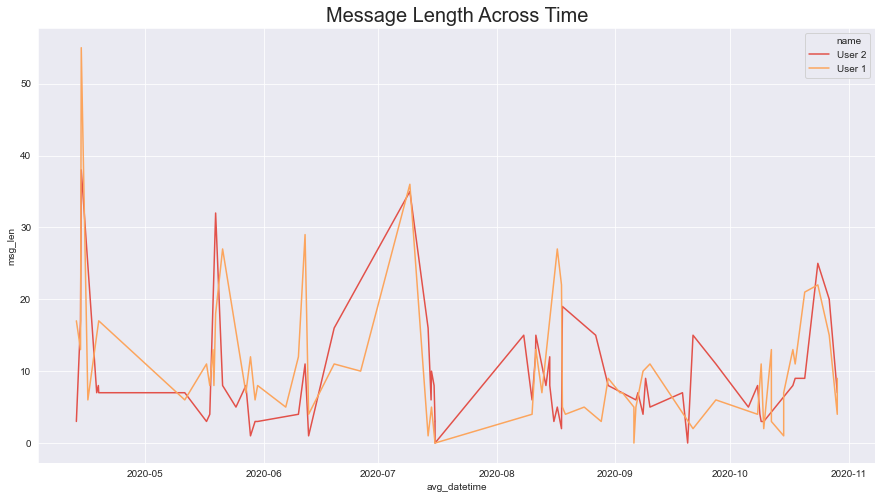

In [206]:
plt.figure(figsize=(15,8))
plt.title('Time Series Data: Message Length')
sns.lineplot(data=combined_chats,x='avg_datetime',y='msg_len',hue='name')
plt.title('Message Length Across Time',fontdict={'fontsize':20});

#### Emoji Count across Time

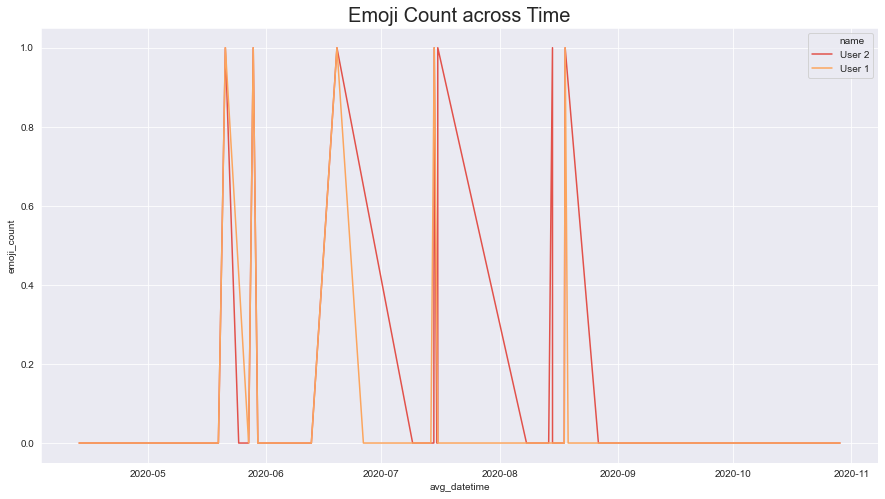

In [207]:
plt.figure(figsize=(15,8))
plt.title('Emoji Count across Time',fontdict={'fontsize':20})
sns.lineplot(data=combined_chats,x='avg_datetime',y='emoji_count',hue='name');

#### Monthly Message Length

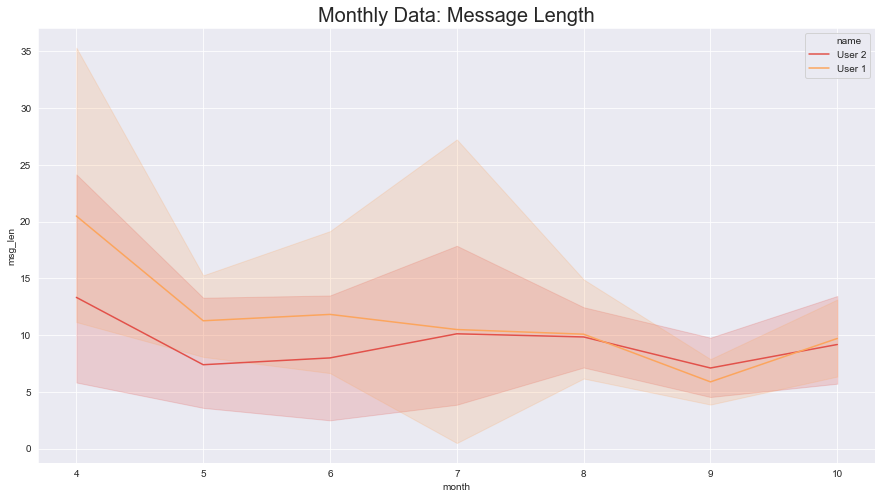

In [208]:
plt.figure(figsize=(15,8))
sns.lineplot(data=combined_chats,x='month',y='msg_len',hue='name')
plt.title('Monthly Data: Message Length',fontdict={'fontsize':20});

#### Monthly Emoji Count

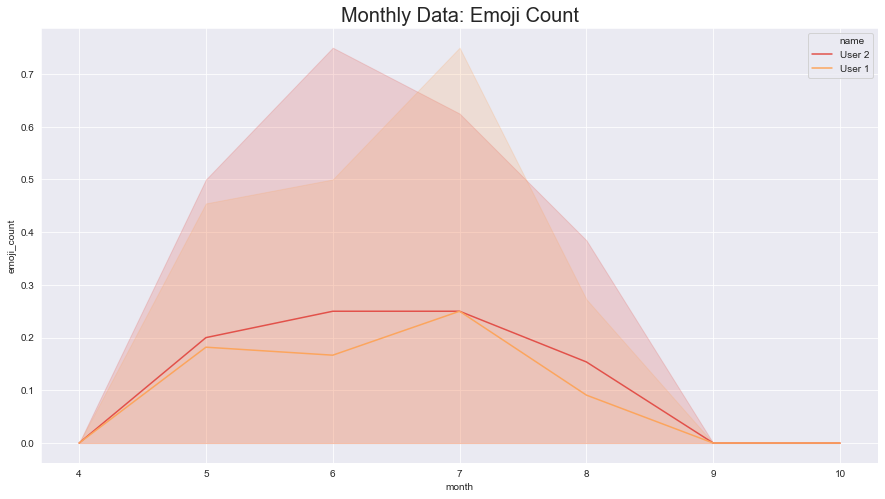

In [209]:
plt.figure(figsize=(15,8))
plt.title('Monthly Data: Emoji Count',fontdict={'fontsize':20})
sns.lineplot(data=combined_chats,x='month',y='emoji_count',hue='name');

#### Day of week message length

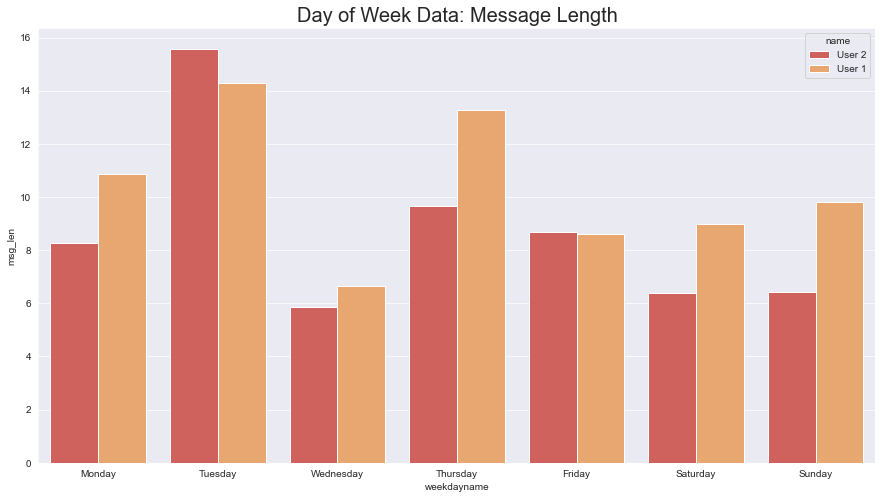

In [210]:
plt.figure(figsize=(15,8))
plt.title('Day of Week Data: Message Length',fontdict={'fontsize':20})
sns.barplot(data=combined_chats,x='weekdayname',y='msg_len',hue='name',ci=None);

#### Day of Week Emoji Count

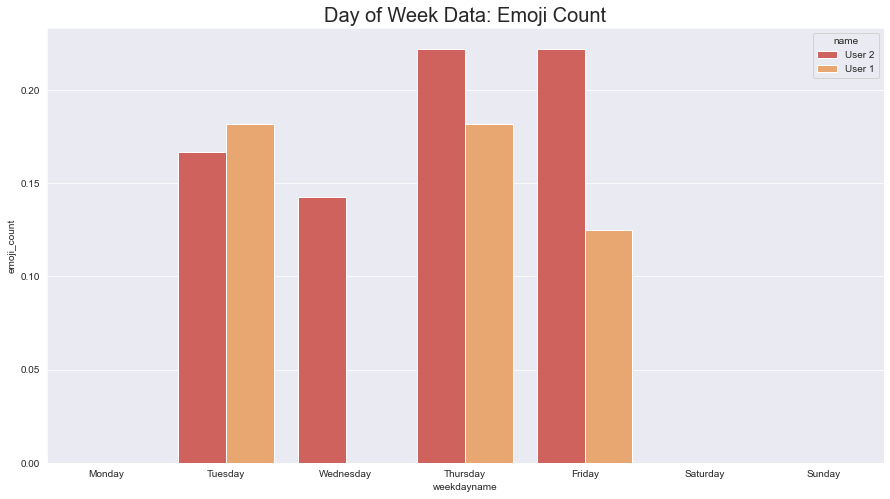

In [211]:
plt.figure(figsize=(15,8))
plt.title('Day of Week Data: Emoji Count',fontdict={'fontsize':20})
sns.barplot(data=combined_chats,x='weekdayname',y='emoji_count',hue='name',ci=None);

#### Day of Week Sticker Count

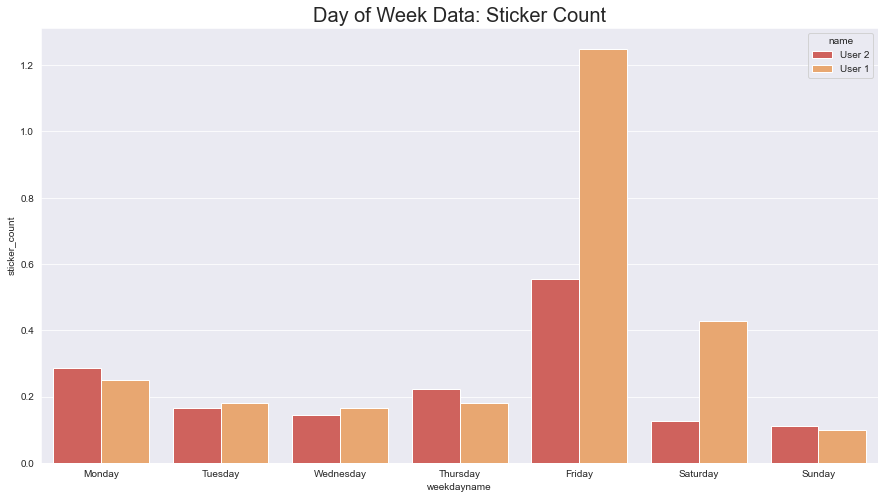

In [212]:
plt.figure(figsize=(15,8))
plt.title('Day of Week Data: Sticker Count',fontdict={'fontsize':20})
sns.barplot(data=combined_chats,x='weekdayname',y='sticker_count',hue='name',ci=None);

# Fitting Emotion Classification Model on Conversations

In [213]:
chat_predict = combined_chats[['content_final','len_exc','len_qn','len_ellip']]
emo_predictions = best_model.predict(chat_predict)
chat_analysis = combined_chats
chat_analysis['predicted_emotion'] = best_model.predict(chat_predict)
chat_analysis['predicted_emotion'].replace(dict_emo_swap,inplace=True)

In [214]:
chat_analysis.sample(2,random_state=9)

,index,group,content_final,msg,name,sticker_count,emoji_count,avg_datetime,len_exc,len_qn,len_ellip,year,month,day,weekdayname,dayofyear,time,date,msg_len,predicted_emotion
61,28,41,Awesome possum Youre wonderful man,Awesome possum! Youre such a wonderful man,User 1,2.0,0.0,2020-09-05 19:58:59.666666752,1.0,0.0,0.0,2020,9,5,Saturday,249,19:58:59.666666,2020-09-05,5,optimistic
3,1,1,Very happy smell freedom,Very happy to smell freedom,User 1,0.0,0.0,2020-06-12 18:10:13.500000000,0.0,0.0,0.0,2020,6,12,Friday,164,18:10:13.500000,2020-06-12,4,optimistic


# Visualisation for Predicted Results
- On Actual Conversations

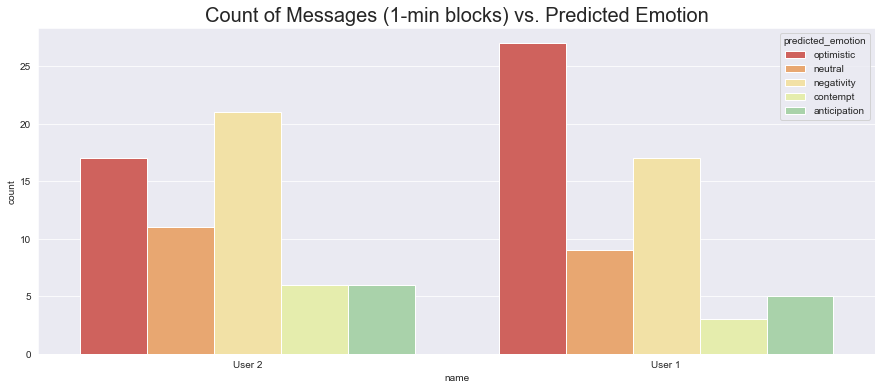

In [215]:
plt.figure(figsize=(15,6))
sns.countplot(data=chat_analysis,x='name',hue='predicted_emotion')
plt.title('Count of Messages (1-min blocks) vs. Predicted Emotion',fontdict={'fontsize':20});

Observation: User 1 tend to send more optimistic messages whilst User 2 tend to send more negative messages. 

#### Overview: Days of Week

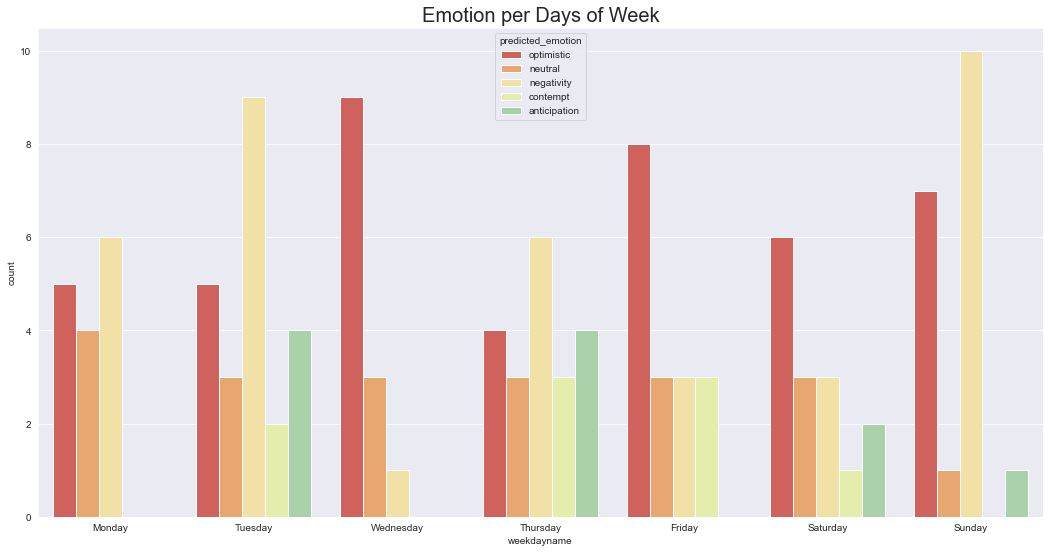

In [216]:
plt.figure(figsize=(18,9))
sns.countplot(data=chat_analysis,x='weekdayname',hue='predicted_emotion')
plt.title('Emotion per Days of Week',fontdict={'fontsize':20});

Observations:
- It appears that messages sent on Thursday tend to be high in negativity and anticipation, but low in optimism. 
- Also, messages on Tuesday appear to have high negativity.
- However, messages exchanged on Sunday appears to have a high optimistic count.

#### Interactive: Days of Week

In [217]:
def dow_display_weekday(daysofweek):
    df_dow = chat_analysis[chat_analysis['weekdayname']==daysofweek]
    return df_dow

daysofweek = widgets.RadioButtons(
options=['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'],
    value='Monday', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
description='Days of Week:',
disabled=False)

display(daysofweek)

RadioButtons(description='Days of Week:', options=('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sa…

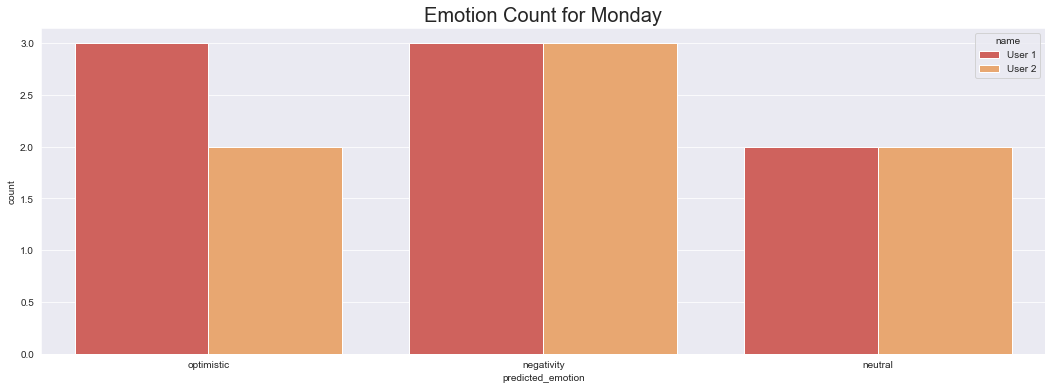

In [218]:
plt.figure(figsize=(18,6))
sns.countplot(data=dow_display_weekday(daysofweek.value),x='predicted_emotion',hue='name')
plt.title(f'Emotion Count for {daysofweek.value}',fontdict={'fontsize':20});

In [219]:
chat_analysis[chat_analysis['month']==8].sample(2,random_state=26)

,index,group,content_final,msg,name,sticker_count,emoji_count,avg_datetime,len_exc,len_qn,len_ellip,year,month,day,weekdayname,dayofyear,time,date,msg_len,predicted_emotion
55,24,36,Dont say like Lets cheerful mood Love awesome lady You best person,Dont say like that Lets have a more cheerful mood Love you awesome lady You are the best person!,User 1,0.0,0.0,2020-08-11 01:53:34.625000192,1.0,1.0,0.0,2020,8,11,Tuesday,224,01:53:34.625000,2020-08-11,12,optimistic
57,25,37,How adorable Like wonderful lady,How adorable Like wonderful lady,User 1,0.0,0.0,2020-08-23 19:55:10.000000000,0.0,0.0,0.0,2020,8,23,Sunday,236,19:55:10,2020-08-23,5,optimistic


#### Overview: Months

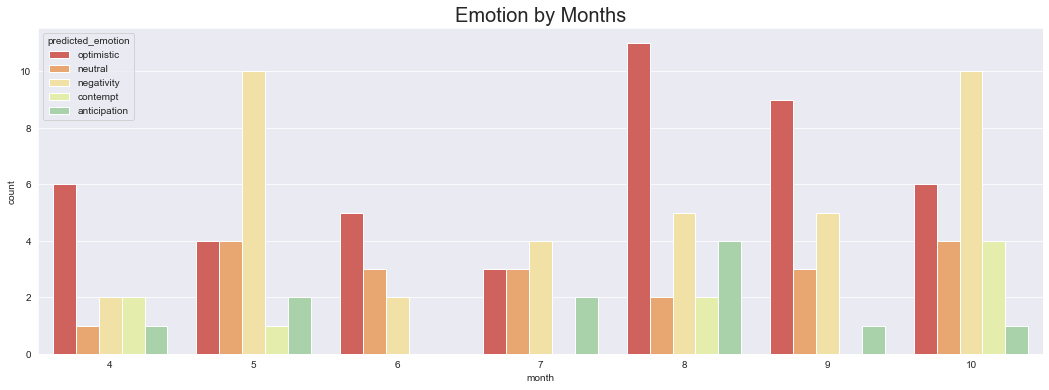

In [220]:
plt.figure(figsize=(18,6))
sns.countplot(data=chat_analysis,x='month',hue='predicted_emotion')
plt.title('Emotion by Months',fontdict={'fontsize':20});

Observations: It appears that August was an optimistic month whilst October was less optimistic with higher negativity.

In [221]:
def dow_display_months(month):
    df_mth = chat_analysis[chat_analysis['month']==month]
    return df_mth

month = widgets.RadioButtons(
options=list(np.sort(chat_analysis['month'].unique())),
    value=4, # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
description='Month:',
disabled=False)

display(month)

RadioButtons(description='Month:', options=(4, 5, 6, 7, 8, 9, 10), value=4)

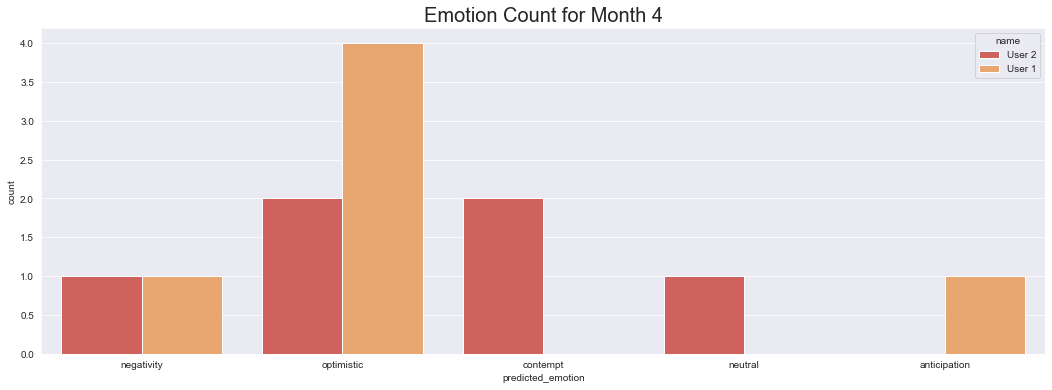

In [222]:
plt.figure(figsize=(18,6))
sns.countplot(data=dow_display_months(month.value),x='predicted_emotion',hue='name')
plt.title(f'Emotion Count for Month {month.value}',fontdict={'fontsize':20});

# Evaluation of Predicted Emotions
- On actual conversations

### Wordcloud

Number of Messages for Emotion optimistic: 44


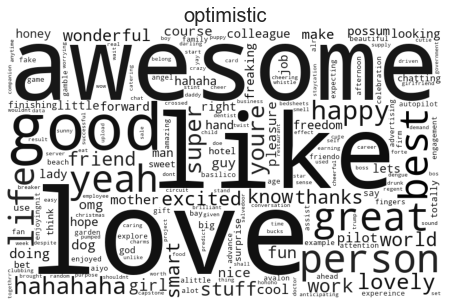

Number of Messages for Emotion neutral: 20


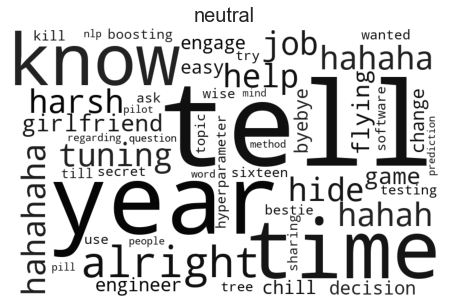

Number of Messages for Emotion negativity: 38


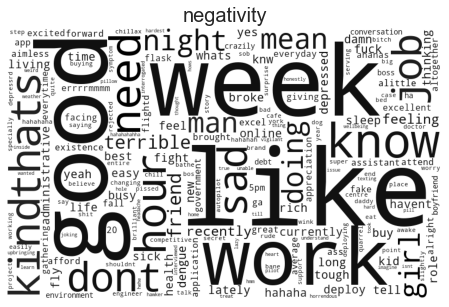

Number of Messages for Emotion contempt: 9


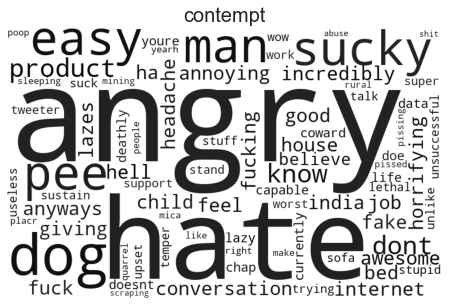

Number of Messages for Emotion anticipation: 11


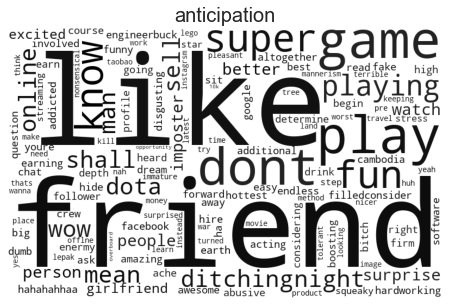

In [223]:
cvec = CountVectorizer(stop_words = stop_list)
cvec23 = CountVectorizer(stop_words = stop_list,ngram_range=(2,3))
list_1 = list(chat_analysis['predicted_emotion'].unique())

from matplotlib.colors import LinearSegmentedColormap
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

for i in list_1:
    cvec_content = cvec.fit_transform(chat_analysis[chat_analysis['predicted_emotion']== i]['content_final'])
    cvec_content = pd.DataFrame(cvec_content.toarray(), columns = cvec.get_feature_names())
    cvec_content_emo = cvec_content.sum().sort_values(ascending=False)
    cvec_content_emo_wc = WordCloud(width = 800, height = 500, background_color ='white',
                  colormap=cmap).generate_from_frequencies(cvec_content_emo)
    len_msg = len(chat_analysis[chat_analysis['predicted_emotion']==i])
    print(f'Number of Messages for Emotion {i}: {len_msg}')
    plt.figure(figsize=(8,5))
    plt.imshow(cvec_content_emo_wc)
    plt.title(i,size=20)
    plt.axis('off')
    plt.show()

Number of Messages for Emotion optimistic: 44


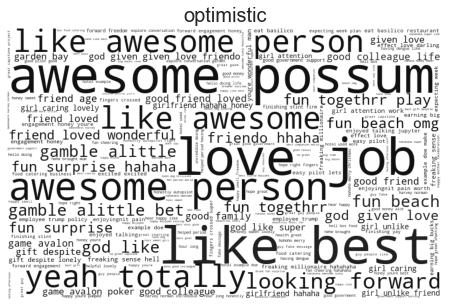

Number of Messages for Emotion neutral: 20


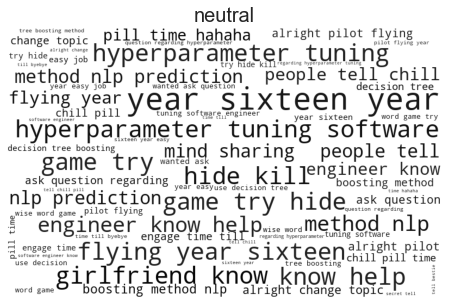

Number of Messages for Emotion negativity: 38


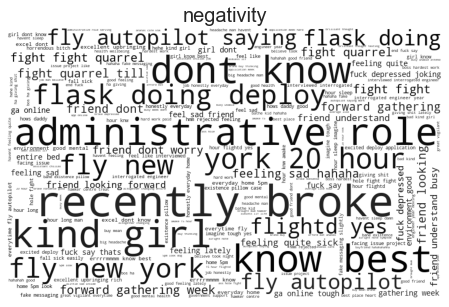

Number of Messages for Emotion contempt: 9


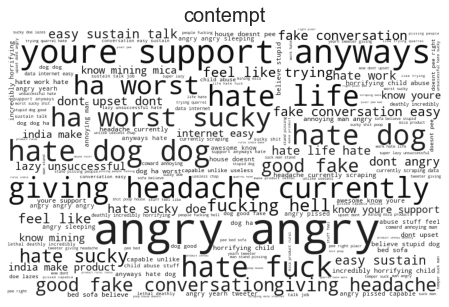

Number of Messages for Emotion anticipation: 11


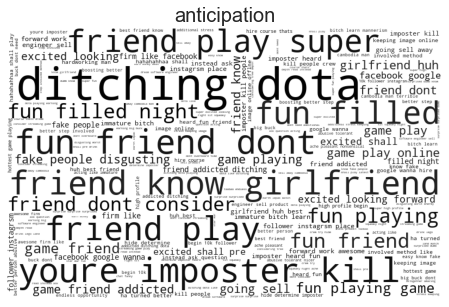

In [224]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

for i in list_1:
    cvec_content = cvec23.fit_transform(chat_analysis[chat_analysis['predicted_emotion']== i]['content_final'])
    cvec_content = pd.DataFrame(cvec_content.toarray(), columns = cvec23.get_feature_names())
    cvec_content_emo = cvec_content.sum().sort_values(ascending=False)
    cvec_content_emo_wc = WordCloud(width = 800, height = 500, background_color ='white',
                  colormap=cmap).generate_from_frequencies(cvec_content_emo)
    len_msg = len(chat_analysis[chat_analysis['predicted_emotion']==i])
    print(f'Number of Messages for Emotion {i}: {len_msg}')
    plt.figure(figsize=(8,5))
    plt.imshow(cvec_content_emo_wc)
    plt.title(i,size=20)
    plt.axis('off')
    plt.show()

As the predictive model aims to understand the tonality of the message, we will be able to reveal some of the key topics that arise through these users' conversations given the tonality of their messages.

**Optimistic**
- For optimistic messages, it is apparent that 'love' appears a lot in messages that were optimistic. 
- Other topics could be better analysed through the CountVectorizers' bi/tri-grams. It appears that 'awesome person' and 'love job' is a big topic when the users sound optimistic in their chat conversations. 
- Moreover, words that were frequently used included "awesome", "great", 'like','good'. 

**Neutral**
- Neutral messages generally consist of more daily casual conversations, and random topics. 
- Wordcloud did not point towards any significant words that carries much emotions
  - ie. 'friend','alright','year','know','buy'
- N-gram bigrams/trigrams word clouds shows the common topics that were raised in the chat conversations between the two parties.

**Negative**
- It appears that 'work' and 'job' is heavily associated with messages that sounded negative.
- It also appears from bi/trigrams wordcloud that the term 'chill pill' is a common term used by users in a negative message.

**Contempt**
- The wordclouds exhibit strong emotions. 
- For unigram wordcloud, words that frequently appear in contempt messages include "angry",'hate','quarrel','pissed'
- We can analyse that 'dog' could either be interpreted as a lingo for scolding people, or an actual dog. 
  - By the looks of the bi/trigram wordcloud, we can conclude that the user have deep resentment for dogs and actually 'hates' them. 

**Anticipation**
- In the users' context, messages labelled as anticipation appear to point towards gaming/playing with friends a lot. 
- Even for bi/trigram word clouds, most of the words were regarding gaming and playing. 
- This shows that the users' are generally more excited about this subject matter.


### Text Messages

**Optimistic**

In [228]:
chat_analysis[chat_analysis['predicted_emotion']=='optimistic'][['msg']].sample(10,random_state=23)

,msg
98,So looking forward to our engagement honey You're the best girlfriend ever Hahaha Honey me too Sweet lovely you Cutie boy!! 🤗 You shouldn't do this to me!!!
85,Hais Okay she is a sweet girl Caring Always there for me Lovely angel Parents are nice Good family
58,Perhaps you can be a sales person Charms the whole world Thanks man
63,God given Love you friendo Hhaha
43,Daddy loves me a. Lot
64,Awesome haha But then what about your work That is a little worrying?
55,Dont say like that Lets have a more cheerful mood Love you awesome lady You are the best person!
19,yeah thank god i am not like that i am always super driven
72,OH!!!! That's super awesome to hear; so happy for you!! Like best bosses and good colleague Your life is set!!! Kudos
41,His health is great


It appears that all 10 messages were well classified to exemplify a sense of happiness and optimism. Model appears to have predicted these messages well.

**Neutral**

In [229]:
chat_analysis[chat_analysis['predicted_emotion']=='neutral'][['msg']].sample(10,random_state=23)

,msg
2,Hahahaha
75,Tell me more?? Bestie
9,Oh mind sharing
5,Why so
31,Alright let's change topic
36,hahah what
92,Should i use decision tree or boosting methods for my NLP predictions?
99,okay testing's over
22,people tell me to take a chill pill all the time hahaha
106,Alright I am a pilot I have been flying over the years for sixteen years already Not an easy job at all


Generally, these sampled messages are on random topics (ie. buying bedsheets, hyperparameter tuning, participation in a survey etc).
However, there are some messages that appear to be rather optimistic. 
- For example, #2: Hahahaha

This model is unable to pick up the variations in laughters in chat conversations: 'hahha',"hahaah','hahaa' etc. 

**Negativity**

In [273]:
chat_analysis[chat_analysis['predicted_emotion']=='negativity'][['msg']].sample(10,random_state=44)

,msg
65,Your boss has been giving shit to you lately isn't it
24,And how I need to see a doctor all the time
30,So pissed off.
104,sure. now it feels like i am being interviewed or interrogated by you. I have been a systems engineer for 4 years before moving into a more administrative role
51,Let's surprise our friends??? I'm so so so looking forward to our gathering next week
108,I mean not easy to get the job but once I am a pilot my life is great No la we are always vigilant everytime we fly Autopilot is just a saying Work hours are long man I fly to New York 20 hours you knw I have to be awake for at least 15 hours during these flightd Yes I have been
37,Damn You rich kid I can only afford to eat at ananas cafe you knw I brought my mum to hawker centre so I can treat her to a mesl
103,We should talk about more neutral conversations Perhaps you tell me what specially you are doing at your job?
7,Miss boyfriend ah Hahahahahha
68,Shouldn't work in this kind of environment Not good for your mental health and wellbeing


It appears that most of the messages were well classified, despite not showing obvious words that were negative.
- For example: #24: "And how I need to see a doctor all the time"
    - Perhaps, the model has classified 'doctor' to be a negative term and predicted associated messages as such.

Model has evaluated a seemingly neutral message to be negative:
- For example: #104: "sure. now it feels like i am being interviewed or interrogated by you. I have been a systems engineer for 4 years before moving into a more administrative role"
    - This message, despite appearing to be rather 'neutral' at first glance, has indeed a slight negativity associated with it. "feels like i am being interviewed or interrogated by you" is sentence that has an element of surprise and apprehension attached. 
- For example: #103: "We should talk about more neutral conversations Perhaps you tell me what specially you are doing at your job?"

However, the model has predicted the following message, which appears to be "anticipatory" in its tonality, into negativity as well.
- For example: #51: Let's surprise our friends??? I'm so so so looking forward to our gathering next week

We believe that the model could be improved upon to reduce the misclassification of other emotion classes into "negativity" class.

In [278]:
chat_analysis[chat_analysis['predicted_emotion']=='anticipation'][['msg']].sample(10,random_state=23)

,msg
94,Yeah I think boosting is better There are many steps involved in this method Like considering tree depth and all You should go read up about it Instead of ask me so many questions!!!??? Not sure why you are acting up like that You sure are an immature bitch You should learn some mannerism I'm going to sell you away to cambodia man Terrible!!!
112,Hahahahhaa Shall we play amongst us?? The latest hottest game that everyone is playing now
76,Wow so hardworking man
118,"right now when I sit on it , it is even very squeaky every night my back aches And it is not pleasant. Lol. Nonsensical chats. So funny haha."
82,😂 Don't go too overboard ok Take some time off to travel the earth Or perhaps just lepak And watch some movies With your girlfriend Huh! I'm your best friend how can I not know that you have a girlfriend???
48,So excited Shall we go for pre drinks??? We can go to Lego Land or watch star wars together Perhaps that would be a fun filled night
115,I mean If you're an imposter you kill people But if you are a crew you try to hide and determine the imposter?? Heard is fun from my friends Why don't you consider streaming your game play online? Can perhaps earn some money I mean you are already super high profile to begin with With 10k followers on your instagrsm I'm sure there is a place for you!
66,nah he has turned around and became a better person less abusive more tolerant nicer person altogether. Amazing
114,Yes! We should all call our friends and play together! Haha Im sure it will be super fun playing this game together My friends and i are addicted to it I am ditching dota already Like all of us are ditching dota We are only playing amongst us I am already earning big bucks. Dont need the additional stress of keeping up my image both online and offlne Not easy you know Fake people are disgusting My worst enermy
96,Wow our make up are from there? Surprise surprise 🤗 Why are you surprised Dumb of you not to know that???


Anticipation, which is the emotion class that has performed the worst in our model, has done decently well in predicting these messages.
- The only messages that I would disagree with regarding the prediction is #118: "right now when I sit on it , it is even very squeaky every night my back aches And it is not pleasant. Lol. Nonsensical chats. So funny haha.'.
- The word 'Wow' in #76 could have been the reason why the message has been classified as such. 
- As we understood from the word cloud, messages for 'anticipation' largely revolves around playing games and having fun.
    - These elements are also key predictors for this emotion class, as noted from our previous notebook.

In [277]:
chat_analysis[chat_analysis['predicted_emotion']=='contempt'][['msg']].sample(9,random_state=26)

,msg
26,I am angry Pissed off at how you are so capable unlike me A useless chap
95,Btw do you know about mining mica products in a rural part of india? Our make up products are from there Very very lethal and deathly Incredibly horrifying Child abuse and stuff I feel like im trying to quarrel with myself I HATE work I hate life I hate everyone!!!! Fuck everything!
28,Angry angry angry Sleeping whole day
25,wow don't be upset dont be angry
18,Super lazy and unsuccessful Really hate it that she is so so sucky in what she does and lazes around all day
14,Awesome will always know that you're here to support me Anyways I really hate my dog My dog has the worst sucky shit ever He poops everywhere around the house And doesn't pee at the right placr He pees even on my bed and sofa CAN YOU BELIEVE IT?????!!!!! Stupid dog! Good for you This fake conversation is not easy to sustain What should we talk about How is your job
56,Why? Your temper sucks man I really cannot stand it It is pissing people off Fucking hell
54,Lol You coward So annoying man Anyhow also get angry
29,why are you angry? yearh tweeter is giving me a headache! i am currently scraping data from the internet and it is NOT easy at all


As noted from our previous notebook, messages that contains vulgarities and hate words would fall under this category.
- We could see that the words 'angry','pissed','annoy','terrible','stupid' and vulgarities are common across these messages.
- It appears that this model has classified these messages rather welll. The only exception could be #25, where it appears to be a negative message. However, the message could have been influenced by the word 'angry' which hence was classified under "contempt".

In [279]:
cols_to_dummy = ['year','month','weekdayname','predicted_emotion']

In [280]:
chat_dummy = pd.get_dummies(chat_analysis,columns=cols_to_dummy)
chat_dummy.shape

(122, 36)

In [281]:
cols_heatmap = chat_dummy.columns.tolist()

In [282]:
cols_heatmap.remove('index')            # Not useful information. 
cols_heatmap.remove('year_2020')        # only one year is present. Not useful
cols_heatmap.remove('len_ellip')        # not present in our messages.
cols_heatmap.remove('day')              # Not useful in our heatmap analysis 
cols_heatmap.remove('dayofyear')        # Not useful in our heatmap analysis

cols_heatmap.remove('month_4')          # We are not focusing on months for heatmap analysis 
cols_heatmap.remove('month_5')       
cols_heatmap.remove('month_6')        
cols_heatmap.remove('month_7')              
cols_heatmap.remove('month_8')      
cols_heatmap.remove('month_9')            
cols_heatmap.remove('month_10')    

cols_heatmap.remove('msg_len')          # Irrelevant as we have grouped messages in 1 minute blocks
cols_heatmap.remove('group')            # Irrelevant

In [283]:
chat_dummy = chat_dummy[cols_heatmap]

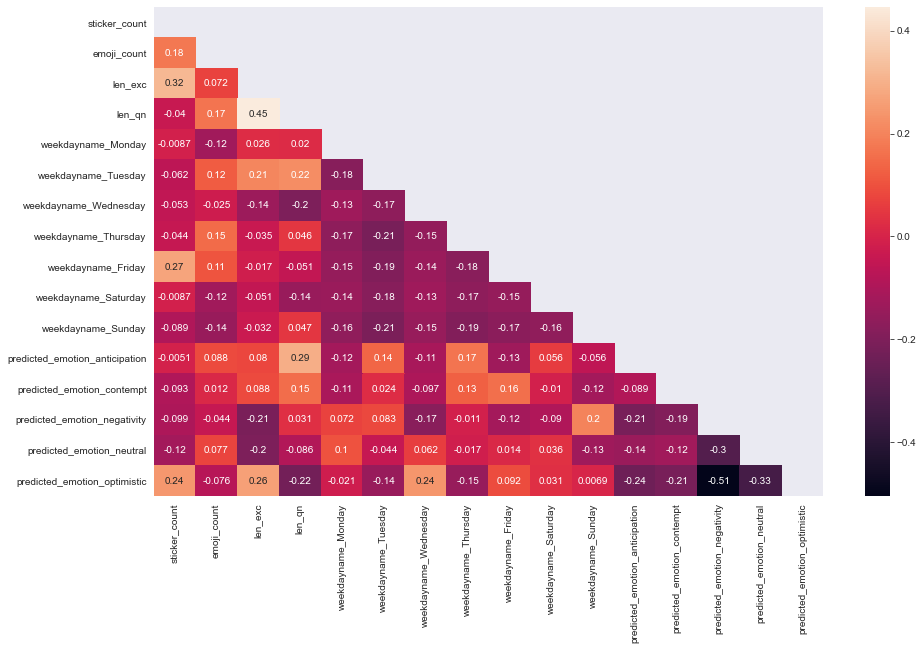

In [284]:
plt.figure(figsize=(15,9))
custom_mask = np.zeros_like(chat_dummy.corr())   
custom_mask[np.triu_indices_from(custom_mask)] = True
sns.heatmap(chat_dummy.corr(),mask=custom_mask,annot=True);

**Observations:**
- Thursdays are negatively correlated with optimistic messages whilst positively correlated with anticipation messages.
- Fridays are negatively correlated with negative messages
- Question marks and exclamation marks appear to be positively correlated.

# Evaluation of Model - Summary

**Testing of Data on Casual Chat Conversations**
- From a qualitative evaluation standpoint, our model has predicted the tonalities of our casual chat messages fairly well.
- "Negativity" class tended to be a catch-all for misclassified classes. From our sample testing results, we observe that many messages that appeared to be "neutral" or "anticipatory" were misclassified into "negativity" class.
- In general, our model has performed really well for "Optimistic","Neutral","Anticipation" and "Contempt", as we observe from sampled data.

# Limitations
#### Overall:
- Overarching this project was the limitation of obtaining approved, open-source chat conversations (from Whatsapp, Telegram) for us to build the most accurate model. 
    - Even if we have obtained chat conversations, there is an additional, costly, barrier that we have to overcome: labelling the emotions and labelling them *accurately*. 
- We have chosen to use tweet dataset as a replacement for actual chat conversations due to the nature of tweets, to be highly casual and conversational in nature, which is a good substitute in predicting emotions in chat conversations.

#### Modelling
- The main limitation of our model was the use of mislabelled data from the manual annotators. There are a large bulk of misclassified data (based on our model) where we lean more towards agreeing with model's prediction instead of the actual labels. 
- Natural Language Processing on Casual Chat Conversations tend to have many limitations attached, and is not a straightforward topic:
    - One of the key flaws in our model was the inability for it to understand contextual meaning of certain words, ie. "sick". 
    - Another key aspect was the inability to differentiate the same words with different spellings: 'hahahaha','haahaa' etc. as well as stretched words "tireedddddddd" vs. 'tired'.
    - Another area of concern was the potentials to have spelling mistakes and underweighting these words in our model, ie. "goodmorning" (one word) vs. 'good morning' (two words); 'chillin' vs. 'chilling'. 


# Areas of Improvement & Next Steps

With our first attempt at building an emotion classification prototype for our communication platform, there are certainly areas of improvements and key learning points that we can takeaway from this attempt. 

For the second iteration, we will be suggesting improvements as following:
- To scrape Twitter by filtering hashtags to obtain more relevant content. We would also like to increase the number of tweets in our dataset and ensure a balanced dataset for each emotion class before we start modelling.
- Conduct deep cleansing of our data:
    - Take into account 'stretched words' and their effect on our predictive capabilities. This can be done by filtering for letters that appear consequetively more than 3 times (ie. 'tweeeets'). We can capture this information through another column in our dataframe.
    - Understand some of the commonly mispelled words, ie: 'ahaha', 'hahha' etc.
    - Using Symspell's library to correct the whole dataset to ensure words are correctly sent for model training.
- Conduct more sampling of data to see effectiveness of our model: Currently, our sample size is at 10 tweets.
- Finally, as we attempt to obtain more data from Twitter, we can also look into other emotion classes that are more specific, ie "Disgust", "Horror" or "Fear" that were absent from our current model.

# In a nutshell

Our team believes that this current prototype, as a minimum viable product, suffices the needs of the team for further development of this value-added service. The current model has fared moderately well on test data (actual chat conversations), and is able to predict casual tonalities well. 

We will be continuing our efforts to develop a better model with the suggested steps detailed above. Concurrently, we hope to collaborate with the software engineering team in implementation of this new function within our communications platform. 